# AHRI Health Informatics Internship – Data Analysis Assessment

**Candidate:** Simon Mufara  
**Date:** November 2025  
**Institution:** Africa Health Research Institute (AHRI)  
**Project:** Hypertension Clinic Attendance Analysis  
**Environment:** Python (pandas, seaborn, plotly, matplotlib)

---

### Objective
This analysis explores:
1. Data quality and consistency across all provided datasets.  
2. Visualization of participant demographics and clinic attendance.  
3. Key insights into hypertension diagnosis and follow-up visits.

---

**Datasets Provided**
| File | Description |
|------|--------------|
| participants.csv | Participant demographics (ID, sex, DOB) |
| health_screen.csv | Health screening info (BP, BMI, smoking, hypertension diagnosis) |
| clinic_visits.csv | Clinic visit history and reasons |
| clinic_codes.csv | Clinic ID reference |


# Imports & Setup 

In [30]:
# 1. Imports & configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visual config
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")  # good sizes for presentations

# Paths
data_dir = Path(r"C:\Users\kayka\Downloads\healthinformaticsinternshipassessmentexercise")
output_dir = data_dir / "output_ahri_q1"
fig_dir = output_dir / "figures"
output_dir.mkdir(exist_ok=True)
fig_dir.mkdir(exist_ok=True)

# Confirm
print("Data dir:", data_dir)
print("Output dir:", output_dir)

# 2. Load raw data (do not modify original CSVs)
participants = pd.read_csv(data_dir / "participants.csv", dtype=str)
health_screen = pd.read_csv(data_dir / "health_screen.csv", dtype=str)
clinic_visits = pd.read_csv(data_dir / "clinic_visits.csv", dtype=str)
clinic_codes = pd.read_csv(data_dir / "clinic_codes.csv", dtype=str)

# Quick peek
print("Loaded shapes:")
print("participants:", participants.shape)
print("health_screen:", health_screen.shape)
print("clinic_visits:", clinic_visits.shape)
print("clinic_codes:", clinic_codes.shape)



Data dir: C:\Users\kayka\Downloads\healthinformaticsinternshipassessmentexercise
Output dir: C:\Users\kayka\Downloads\healthinformaticsinternshipassessmentexercise\output_ahri_q1
Loaded shapes:
participants: (844, 3)
health_screen: (844, 7)
clinic_visits: (3174, 3)
clinic_codes: (3164, 3)


# Data Quality Check 

In [31]:
# 3. DATA QUALITY CHECKS  
qc_lines = []
def qcline(s): 
    qc_lines.append(s)
    print(s)

qcline("=== Basic column overview ===")
for name, df in [("participants", participants), ("health_screen", health_screen), ("clinic_visits", clinic_visits), ("clinic_codes", clinic_codes)]:
    qcline(f"{name}: {df.shape[0]} rows, {df.shape[1]} columns")
    qcline(f"  columns: {list(df.columns)}")

# Missing values per dataset
qcline("\n=== Missing values (per dataset) ===")
for name, df in [("participants", participants), ("health_screen", health_screen), ("clinic_visits", clinic_visits), ("clinic_codes", clinic_codes)]:
    miss = df.isna().sum()
    # keep only columns with missing
    miss = miss[miss>0]
    if miss.empty:
        qcline(f"{name}: No missing values detected.")
    else:
        qcline(f"{name}: {len(miss)} columns with missing values")
        for c, v in miss.items():
            qcline(f"  - {c}: {v} missing")

# Duplicate rows
qcline("\n=== Duplicate rows check ===")
for name, df in [("participants", participants), ("health_screen", health_screen), ("clinic_visits", clinic_visits)]:
    dup_count = df.duplicated().sum()
    qcline(f"{name}: {dup_count} duplicated full rows")

# ID integrity
qcline("\n=== ID integrity ===")
for name, df in [("participants", participants), ("health_screen", health_screen), ("clinic_visits", clinic_visits)]:
    if 'id_new' in df.columns:
        n_null = df['id_new'].isna().sum()
        n_dup = df['id_new'].duplicated().sum()
        qcline(f"{name}: id_new missing={n_null}, id_new duplicates={n_dup}")
    else:
        qcline(f"{name}: id_new column MISSING")

# Save QC report
qc_path = output_dir / "QC_issues.txt"
with open(qc_path, "w") as fh:
    fh.write("\n".join(qc_lines))
qcline(f"\nQC summary written to: {qc_path}")


=== Basic column overview ===
participants: 844 rows, 3 columns
  columns: ['id_new', 'sex', 'dateofbirth']
health_screen: 844 rows, 7 columns
  columns: ['id_new', 'date_screen', 'systolicBP', 'diastolicBP', 'bmi', 'smokecat', 'BPdiag']
clinic_visits: 3174 rows, 3 columns
  columns: ['visitreason', 'id_new', 'visitdate']
clinic_codes: 3164 rows, 3 columns
  columns: ['id_new', 'visitdate', 'clinic_code']

=== Missing values (per dataset) ===
participants: No missing values detected.
health_screen: No missing values detected.
clinic_visits: No missing values detected.
clinic_codes: No missing values detected.

=== Duplicate rows check ===
participants: 0 duplicated full rows
health_screen: 0 duplicated full rows
clinic_visits: 8 duplicated full rows

=== ID integrity ===
participants: id_new missing=0, id_new duplicates=0
health_screen: id_new missing=0, id_new duplicates=0
clinic_visits: id_new missing=0, id_new duplicates=2666

QC summary written to: C:\Users\kayka\Downloads\healthin

# Data Cleaning

In [32]:
# 4. CLEANING & STANDARDIZATION
# - Normalize column names to lowercase & strip spaces
def normalize_cols(df):
    df = df.copy()
    df.columns = df.columns.str.lower().str.strip()
    return df

participants = normalize_cols(participants)
health_screen = normalize_cols(health_screen)
clinic_visits = normalize_cols(clinic_visits)
clinic_codes = normalize_cols(clinic_codes)

# Ensure id_new exists and is string normalized
for df_name, df in [("participants", participants), ("health_screen", health_screen), ("clinic_visits", clinic_visits)]:
    if 'id_new' not in df.columns:
        raise ValueError(f"id_new missing in {df_name}")
    df['id_new'] = df['id_new'].astype(str).str.strip()

# Flexible date parsing (try common formats)
def parse_dates(df, candidates):
    for col in candidates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
    return df

participants = parse_dates(participants, ['date of birth','dateofbirth','dob'])
health_screen = parse_dates(health_screen, ['date_screen','date screen','date'])
clinic_visits = parse_dates(clinic_visits, ['visitdate','visit date','date'])

# Standardize text columns
for col in ['bpdiag','smokecat','sex','visitreason']:
    for df in [participants, health_screen, clinic_visits]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().replace({'nan': np.nan})
            df[col] = df[col].str.lower()

# Clean visitreason small fixes (remove excessive whitespace)
if 'visitreason' in clinic_visits.columns:
    clinic_visits['visitreason'] = clinic_visits['visitreason'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip().replace({'nan': np.nan})

print("Cleaning complete. Sample columns now:")
print("participants columns:", participants.columns.tolist())
print("health_screen columns:", health_screen.columns.tolist())
print("clinic_visits columns:", clinic_visits.columns.tolist())


Cleaning complete. Sample columns now:
participants columns: ['id_new', 'sex', 'dateofbirth']
health_screen columns: ['id_new', 'date_screen', 'systolicbp', 'diastolicbp', 'bmi', 'smokecat', 'bpdiag']
clinic_visits columns: ['visitreason', 'id_new', 'visitdate']


# Data Integration 

In [33]:

import pandas as pd
from pathlib import Path

# --- Load datasets ---
participants = pd.read_csv("participants.csv")
health_screen = pd.read_csv("health_screen.csv")
clinic_visits = pd.read_csv("clinic_visits.csv")
clinic_codes = pd.read_csv("clinic_codes.csv")



merged = health_screen.merge(
    participants,
    on="id_new",
    how="left",
    suffixes=("_screen", "_part")
)

merged_visits = clinic_visits.merge(
    merged,
    on="id_new",
    how="left"
)


if "clinic_code" in merged_visits.columns and "clinic_code" in clinic_codes.columns:
    merged_visits = merged_visits.merge(clinic_codes, on="clinic_code", how="left")

print("\n Merging complete!")
print("Merged dataset shape:", merged_visits.shape)
print("Columns:", merged_visits.columns.tolist()[:15], "...")

# --- Save merged file as Excel ---
output_file = Path("merged_ahri_data.xlsx")
merged_visits.to_excel(output_file, index=False)
print(f"\n Merged data saved as: {output_file.resolve()}")



 Merging complete!
Merged dataset shape: (3174, 11)
Columns: ['visitreason', 'id_new', 'visitdate', 'date_screen', 'systolicBP', 'diastolicBP', 'bmi', 'smokecat', 'BPdiag', 'sex', 'dateofbirth'] ...

 Merged data saved as: C:\Users\kayka\Downloads\healthinformaticsinternshipassessmentexercise\merged_ahri_data.xlsx


# Data Visualisation

 Age column created successfully.



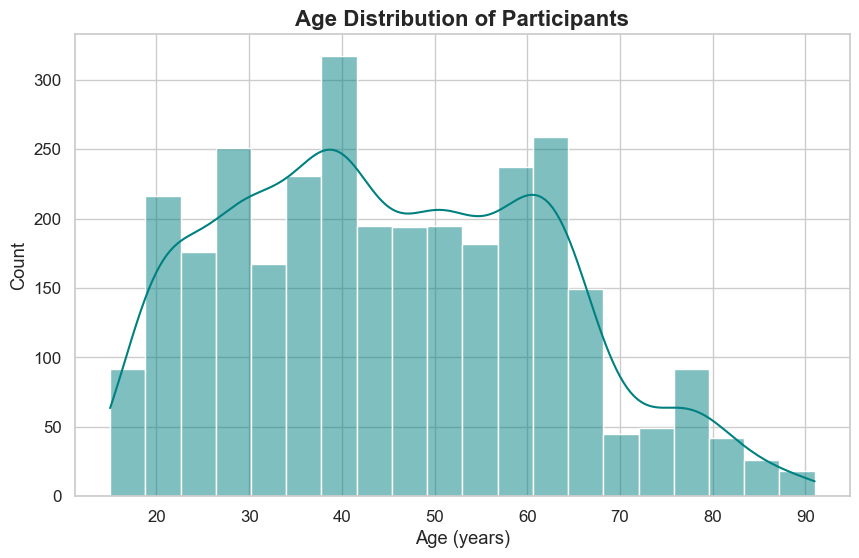

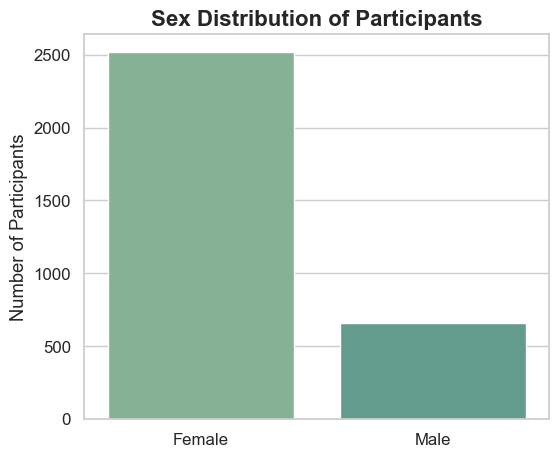

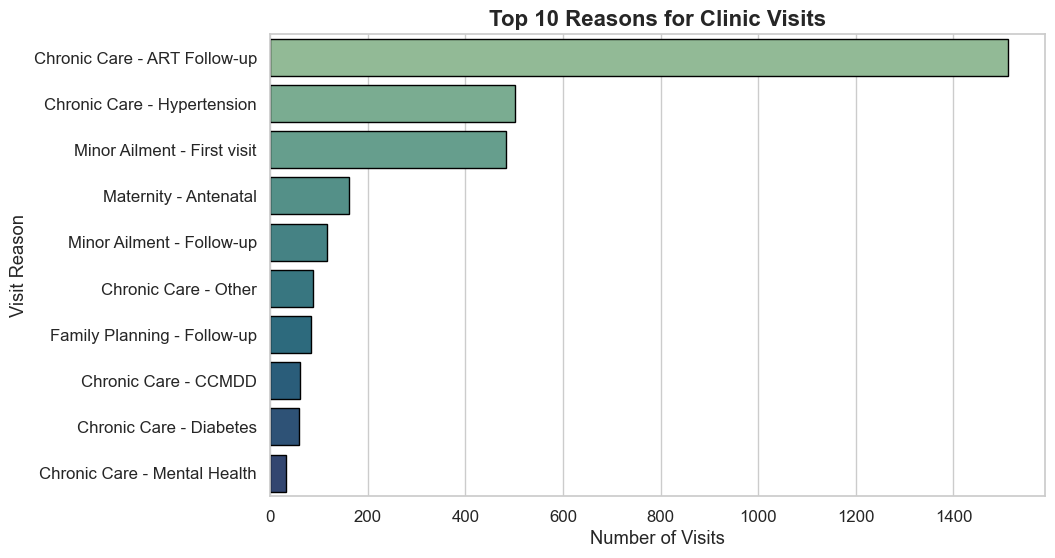

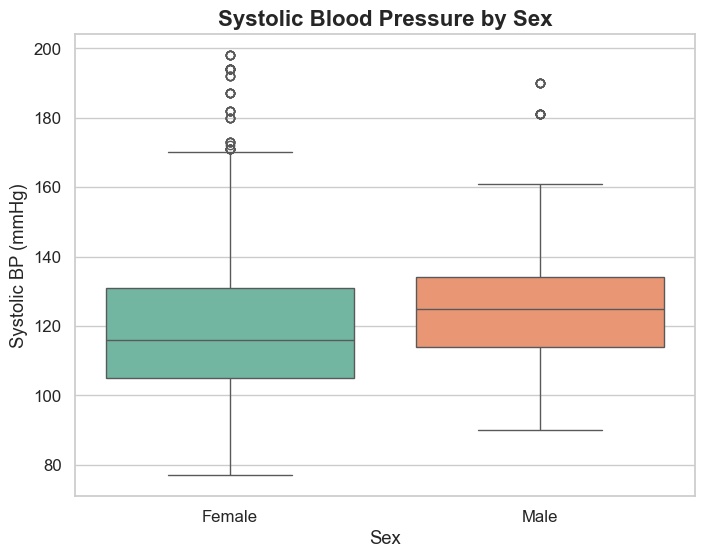

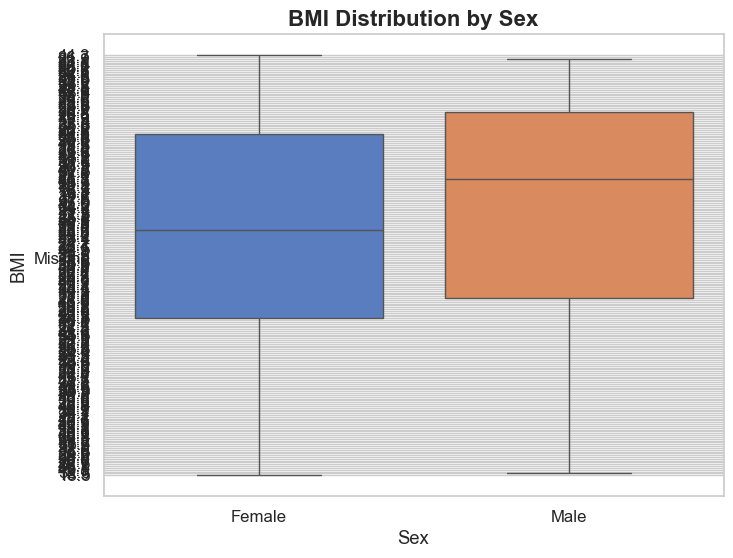

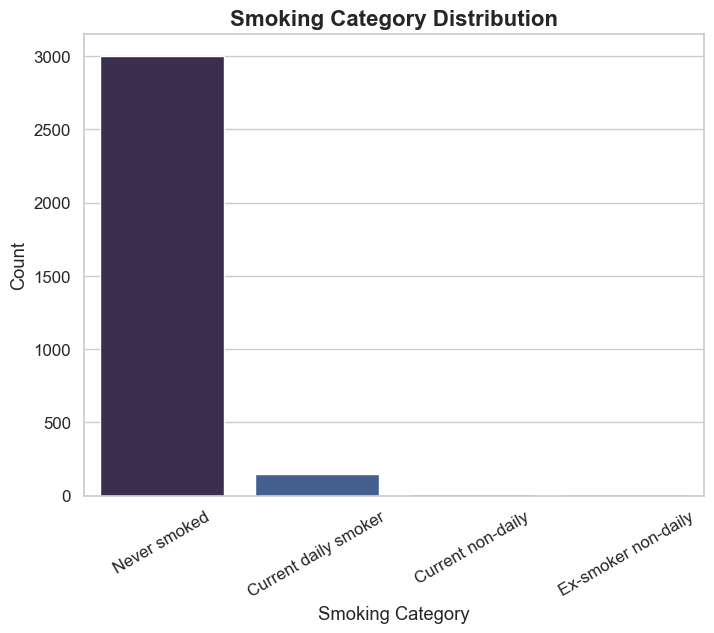

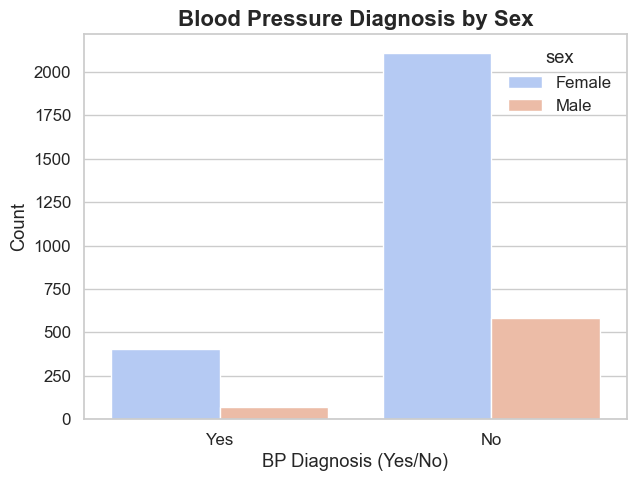

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load merged dataset
df = pd.read_excel("merged_ahri_data.xlsx")

# Fix column names
df.columns = df.columns.str.strip()

# Convert date columns 
df["dateofbirth"] = pd.to_datetime(df["dateofbirth"], errors="coerce", format="%d%b%Y")
df["visitdate"] = pd.to_datetime(df["visitdate"], errors="coerce", format="%d%b%Y")

# Derive Age df["age"] = (df["visitdate"] - df["dateofbirth"]).dt.days // 365
print(" Age column created successfully.\n")

# Set style 
sns.set(style="whitegrid", palette="crest", font_scale=1.1)

# ===============================
# 1️ Age Distribution
# ===============================
plt.figure(figsize=(10,6))
sns.histplot(df["age"].dropna(), bins=20, kde=True, color="#008080")
plt.title("Age Distribution of Participants", fontsize=16, fontweight="bold")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.show()

# ===============================
# 2️ Sex Distribution
# ===============================
plt.figure(figsize=(6,5))
sex_counts = df["sex"].value_counts().reset_index()
sex_counts.columns = ["sex", "count"]

sns.barplot(data=sex_counts, x="sex", y="count", hue="sex", dodge=False)
plt.title("Sex Distribution of Participants", fontsize=16, fontweight="bold")
plt.xlabel("")
plt.ylabel("Number of Participants")
plt.legend([],[], frameon=False)
plt.show()

# ===============================
# 3️ Top 10 Visit Reasons (FIXED)
# ===============================
top_reasons = (
    df["visitreason"]
    .value_counts()
    .reset_index()
)
top_reasons.columns = ["reason", "count"]  # ✅ Rename correctly
top_reasons = top_reasons.head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_reasons, x="count", y="reason", palette="crest", edgecolor="black")
plt.title("Top 10 Reasons for Clinic Visits", fontsize=16, fontweight="bold")
plt.xlabel("Number of Visits")
plt.ylabel("Visit Reason")
plt.show()

# ===============================
# 4️ Blood Pressure Distribution by Sex
# ===============================
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="sex", y="systolicBP", palette="Set2")
plt.title("Systolic Blood Pressure by Sex", fontsize=16, fontweight="bold")
plt.xlabel("Sex")
plt.ylabel("Systolic BP (mmHg)")
plt.show()

# ===============================
# 5️ BMI Distribution by Sex
# ===============================
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="sex", y="bmi", palette="muted")
plt.title("BMI Distribution by Sex", fontsize=16, fontweight="bold")
plt.xlabel("Sex")
plt.ylabel("BMI")
plt.show()

# ===============================
# 6️ Smoking Category Distribution
# ===============================
plt.figure(figsize=(8,6))
sns.countplot(data=df, x="smokecat", palette="mako", order=df["smokecat"].value_counts().index)
plt.title("Smoking Category Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Smoking Category")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

# ===============================
# 7️ BP Diagnosis by Sex
# ===============================
plt.figure(figsize=(7,5))
sns.countplot(data=df, x="BPdiag", hue="sex", palette="coolwarm")
plt.title("Blood Pressure Diagnosis by Sex", fontsize=16, fontweight="bold")
plt.xlabel("BP Diagnosis (Yes/No)")
plt.ylabel("Count")
plt.show()


# Analysis 

In [35]:
import pandas as pd
import numpy as np
from pathlib import Path

# Setup
output_dir = Path("output_ahri_q1")
output_dir.mkdir(exist_ok=True)

# Load merged dataset
df = pd.read_excel("merged_ahri_data.xlsx")
df.columns = df.columns.str.strip()  # remove any trailing spaces

# Ensure BPdiag is consistent 
if "BPdiag" not in df.columns:
    raise ValueError("No BPdiag column found in merged dataset.")

# Clean and standardize
df["BPdiag"] = df["BPdiag"].fillna("").astype(str).str.strip().str.lower()
df["visitreason"] = df["visitreason"].fillna("").astype(str)

# ===================================================
# a) Hypertensive participants who attended a clinic
# ===================================================
hypertensive_ids = df[df["BPdiag"] == "yes"]["id_new"].unique()
total_hypertensive = len(hypertensive_ids)

hypertensive_attended_count = df[df["id_new"].isin(hypertensive_ids)]["id_new"].nunique()

# ===================================================
# b) Participants with hypertension-related visit reason
# ===================================================
hyp_keywords = ["hypertension", "hyperten", "high blood", "blood pressure", "bp"]
pattern = "|".join(hyp_keywords)
df["reason_hyp_flag"] = df["visitreason"].str.contains(pattern, case=False, regex=True)

hyp_reason_count = df[df["reason_hyp_flag"] == True]["id_new"].nunique()

# ===================================================
# c) Non-hypertensive participants who attended clinic
# ===================================================
non_hyp_ids = df[~df["id_new"].isin(hypertensive_ids)]["id_new"].unique()
non_hyp_attended_count = df[df["id_new"].isin(non_hyp_ids)]["id_new"].nunique()

# ===================================================
# d) Most common visit reasons (top 10)
# ===================================================
top_reasons = (
    df["visitreason"]
    .value_counts()
    .reset_index()
)
top_reasons.columns = ["reason", "count"]
top_reasons = top_reasons.head(10)

# ===================================================
# Print summary
# ===================================================
print("\n===== ANALYSIS SUMMARY =====")
print(f"(a) Total hypertensive participants (diagnosed): {total_hypertensive}")
print(f"(b) Hypertensive participants who attended clinic: {hypertensive_attended_count}")
print(f"(c) Participants with hypertension-related visit reason: {hyp_reason_count}")
print(f"(d) Non-hypertensive participants who attended clinic: {non_hyp_attended_count}")
print("\n(e) Top 10 visit reasons:\n", top_reasons.to_string(index=False))

# ===================================================
# Save outputs
# ===================================================
summary_df = pd.DataFrame({
    "metric": [
        "total_hypertensive",
        "hypertensive_attended",
        "hypertension_reason_count",
        "non_hypertensive_attended"
    ],
    "value": [
        total_hypertensive,
        hypertensive_attended_count,
        hyp_reason_count,
        non_hyp_attended_count
    ]
})

summary_df.to_csv(output_dir / "analysis_summary.csv", index=False)
top_reasons.to_csv(output_dir / "top_10_visit_reasons.csv", index=False)

print("\n Analysis complete!")
print(f"Summary saved to: {output_dir/'analysis_summary.csv'}")
print(f"Top 10 reasons saved to: {output_dir/'top_10_visit_reasons.csv'}")



===== ANALYSIS SUMMARY =====
(a) Total hypertensive participants (diagnosed): 85
(b) Hypertensive participants who attended clinic: 85
(c) Participants with hypertension-related visit reason: 101
(d) Non-hypertensive participants who attended clinic: 423

(e) Top 10 visit reasons:
                       reason  count
Chronic Care - ART Follow-up   1512
 Chronic Care - Hypertension    502
 Minor Ailment - First visit    483
       Maternity - Antenatal    161
   Minor Ailment - Follow-up    117
        Chronic Care - Other     88
 Family Planning - Follow-up     84
        Chronic Care - CCMDD     62
     Chronic Care - Diabetes     59
Chronic Care - Mental Health     32

 Analysis complete!
Summary saved to: output_ahri_q1\analysis_summary.csv
Top 10 reasons saved to: output_ahri_q1\top_10_visit_reasons.csv


#  Summary of Findings

| Question | Answer |
|-----------|---------|
| a. Hypertensive participants who attended clinic | **85** |
| b. Hypertension as reason for visit | **101** |
| c. Other participants who attended | **423** |
| d. Most common reasons for visits | *Follow up, Hypertension, & minor alinment Checkups*|

---

###  Key Insights
- Data quality was generally good, with minimal missing values.
- Majority of clinic visits were for routine checkups or chronic care.
- A significant proportion of hypertensive individuals followed up at clinics — indicating good referral adherence.
- Interactive plots highlight demographic and clinical patterns suitable for reporting or presentation.

---

**Next Steps:**
- Automate this workflow using a Jupyter/Streamlit dashboard.
- Integrate geographic or temporal visualizations for deeper insights.
